In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from zipfile import ZipFile
A = ZipFile('/content/drive/MyDrive/clustering_data.zip')
names = A.namelist()


In [3]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/clustering_data.zip', 'r') as z:
  A = z.extractall()

In [4]:
import pandas as pd
import numpy as np 

df_train = pd.read_csv(names[1])

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
df_train.head(5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0


In [7]:
from sklearn.cluster import MiniBatchKMeans, KMeans
import matplotlib.pyplot as plt

np.unique(df_train['state'])

array(['CON', 'ECO', 'FIN', 'INT', 'PAR', 'REQ', 'RST', 'URN', 'no'],
      dtype=object)

Just go check that train data correct 

In [8]:
df_train.isnull().values.any()


False

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


#imputer = SimpleImputer(strategy='most_frequent')
#imputer.fit(x_train)
#x_train = pd.DataFrame(imputer.transform(df_train), columns=df_train.columns)

def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names(features_name))
    new_df = pd.concat([df, new_cols], axis=1)    
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

encoder = OneHotEncoder(sparse=False, drop='first')
f_names = ['proto', 'service' , 'state']
encoder.fit(df_train[f_names])
x_train = ohe_new_features(df_train, f_names, encoder)
#x_test = ohe_new_features(x_test, f_names, encoder)

# feature scaling
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)


#x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#norm_data = StandardScaler().fit_transform(x_train)
pca = PCA()
pca.fit(x_train)

PCA()

In [11]:
x_train.shape

(175341, 191)

After OneHotEncoder there are a lot of new features - I suppose that many of them are almost useless - let's check this hypothesis and see how many important features:
*Lets* check  cumulative variance plot 
it is considered optimal when this value is matured> 80% as can be seen from the graph 5 components of all possible features are enough for this

Text(0.5, 1.0, 'Graph for pick num of importnt features ')

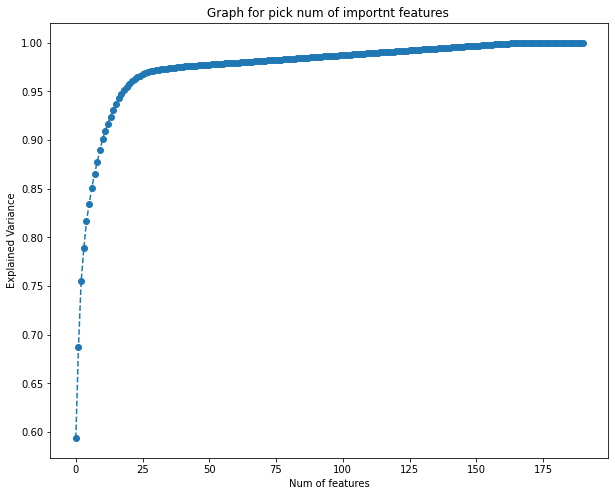

In [12]:
pca.explained_variance_ratio_
plt.figure(figsize=(10,8))
plt.plot(range(0,(x_train.shape[1])), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle = '--')
plt.xlabel("Num of features")
plt.ylabel("Explained Variance")
plt.title("Graph for pick num of importnt features ")

In [13]:
pca = PCA(n_components=5)
pca.fit(x_train)
scores_pca =pca.transform(x_train)

In [14]:
wcss = []#within-cluster sum of squares
for i in range(1,21):
  k_means_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
  k_means_pca.fit(scores_pca)
  wcss.append(k_means_pca.inertia_)

Text(0.5, 1.0, 'K-Means with PCA clustering')

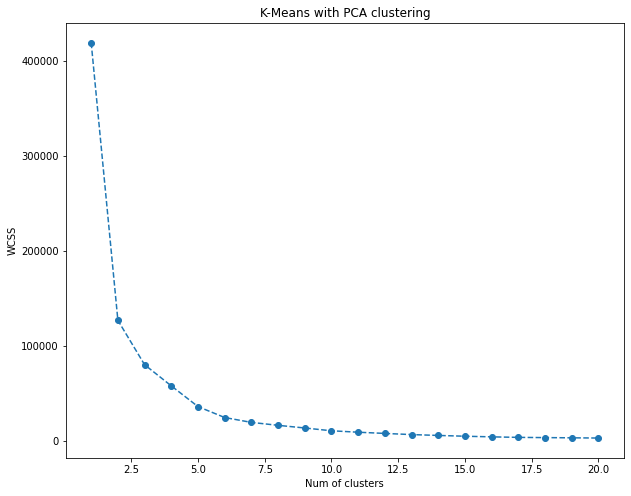

In [15]:
plt.figure(figsize =(10,8))
plt.plot(range(1,21),wcss,marker='o', linestyle='--')
plt.xlabel("Num of clusters")
plt.ylabel("WCSS")
plt.title("K-Means with PCA clustering")

Now let's use the elbow rule to determine the number of clusters on the graph


In [16]:
### USING ONE HOT ENCODER bad pratice in this case so use simple label encoder and Max Ab scaler

In [17]:
df_train = pd.read_csv(names[1])

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
state=np.unique(list(df_train['state']))
cat_features = ['state', 'proto','service']
#le.fit(df_train['state'])
le.fit(state)

df_train['state'] = le.transform(df_train['state'])

for i in cat_features:
  le.fit(df_train[i])
  df_train[i] = le.transform(df_train[i])


In [19]:

from sklearn.preprocessing import MaxAbsScaler
transformer = MaxAbsScaler().fit(df_train)
X_train = transformer.transform(df_train)

Text(0.5, 1.0, 'K-Means with PCA clustering')

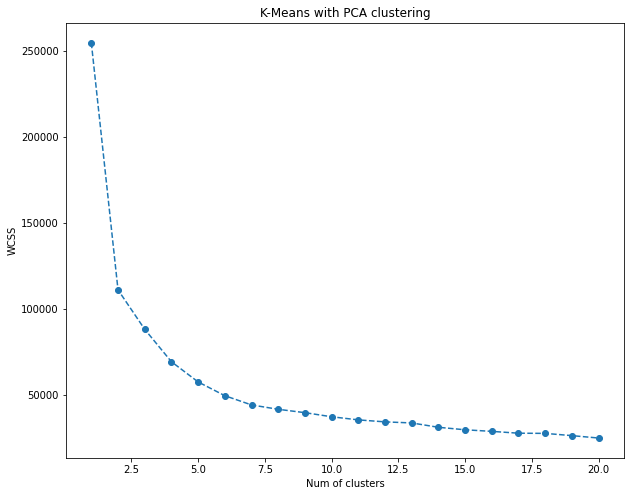

In [20]:
wcss = []
for i in range(1,21):
  k_means_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
  k_means_pca.fit(X_train)
  wcss.append(k_means_pca.inertia_)
plt.figure(figsize =(10,8))
plt.plot(range(1,21),wcss,marker='o', linestyle='--')
plt.xlabel("Num of clusters")
plt.ylabel("WCSS")
plt.title("K-Means with PCA clustering")

In [21]:
#use elbow method and pick 6 num of cluster
kmeans = KMeans(n_clusters=6,random_state=42)
kmeans.fit(X_train)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
cluster_centers = pca.transform(kmeans.cluster_centers_)


In [22]:
X_pca = pd.DataFrame(X_pca, columns=['1','2'])
X_pca['cluster']=kmeans.labels_
cluster_1=X_pca[X_pca['cluster']==0]
cluster_2=X_pca[X_pca['cluster']==1]
cluster_3=X_pca[X_pca['cluster']==2]
cluster_4=X_pca[X_pca['cluster']==3]
cluster_5=X_pca[X_pca['cluster']==4]
cluster_6=X_pca[X_pca['cluster']==5]



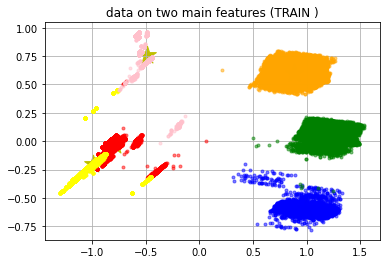

In [23]:
import matplotlib.pyplot as plt
clusters = [cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6]
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='*', c='y', s=350,label='Centroids')
colors = ['red','blue','green','yellow','pink',"orange"]
plt.title("data on two main features (TRAIN )")
for i in range(len(clusters)):
  plt.plot(clusters[i]['1'], clusters[i]['2'], '.', color=colors[i],alpha=0.5)

  #plt.axis([-6, 3, -3, 6])
plt.grid('True')


plt.show()

Lets check their centers

Text(0.5, 1.0, 'Centers')

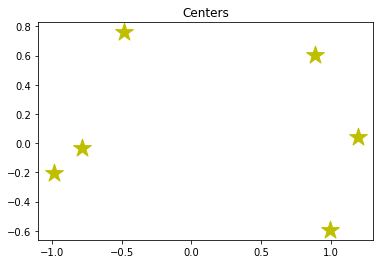

In [24]:
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='*', c='y', s=350,label='Centroids')
plt.title("Centers")


looks good  - lets repeat it with test

In [25]:
df_test = pd.read_csv(names[0])
le = preprocessing.LabelEncoder()
state=np.unique(list(df_test['state']))
cat_features = ['state', 'proto','service']
le.fit(state)
df_test['state'] = le.transform(df_test['state'])

for i in cat_features:
  le.fit(df_test[i])
  df_test[i] = le.transform(df_test[i])


In [26]:
transformer = MaxAbsScaler().fit(df_test)
X_test = transformer.transform(df_test)

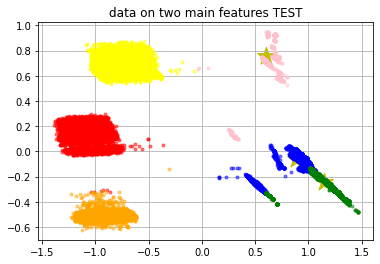

In [27]:
#use elbow method and pick 6 num of cluster
#kmeans = KMeans(n_clusters=6,random_state=42)
#kmeans.fit(X_train)
kmeans.fit(X_test)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
cluster_centers = pca.transform(kmeans.cluster_centers_)
X_pca = pd.DataFrame(X_pca, columns=['1','2'])
X_pca['cluster']=kmeans.labels_
cluster_1=X_pca[X_pca['cluster']==0]
cluster_2=X_pca[X_pca['cluster']==1]
cluster_3=X_pca[X_pca['cluster']==2]
cluster_4=X_pca[X_pca['cluster']==3]
cluster_5=X_pca[X_pca['cluster']==4]
cluster_6=X_pca[X_pca['cluster']==5]

clusters = [cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6]
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='*', c='y', s=350,label='Centroids')
colors = ['red','blue','green','yellow','pink',"orange"]
plt.title("data on two main features TEST")
for i in range(len(clusters)):
  plt.plot(clusters[i]['1'], clusters[i]['2'], '.', color=colors[i],alpha=0.5)
#plt.axis([-6, 3, -3, 6])
plt.grid('True')
plt.show()


In [28]:
cluster_1.shape

(10285, 3)

In [29]:
from sklearn.cluster import Birch
brc = Birch(n_clusters=6)
#brc.fit(X_train)
#brc.transform(X_train)
birch_models=[brc,Birch(n_clusters=None)]
X = X_train

In [30]:
from itertools import cycle
import matplotlib.colors as colors
%matplotlib inline 



In [31]:
# final_step = ["without global clustering", "with global clustering"]
# birch_model = birch_models[1]
# birch_model.fit(X)
# X_pca = pca.fit_transform(X_train)
# X_pca = pd.DataFrame(X_pca, columns=['1','2'])

# # Plot result
# labels = birch_model.labels_
# centroids = birch_model.subcluster_centers_
# n_clusters = np.unique(labels).size
# print("n_clusters : %d" % n_clusters)

# #use elbow method and pick 6 num of cluster
# #kmeans = KMeans(n_clusters=6,random_state=42)
# #kmeans.fit(X_train)
# #kmeans.fit(X_test)
# #pca = PCA(n_components=2)
# #X_pca = pca.fit_transform(X_test)
# cluster_centers = pca.transform(centroids)
# #X_pca = pd.DataFrame(X_pca, columns=['1','2'])
# X_pca['cluster']=labels
# cluster_1=X_pca[X_pca['cluster']==0]
# cluster_2=X_pca[X_pca['cluster']==1]
# cluster_3=X_pca[X_pca['cluster']==2]
# cluster_4=X_pca[X_pca['cluster']==3]
# cluster_5=X_pca[X_pca['cluster']==4]
# cluster_6=X_pca[X_pca['cluster']==5]

# clusters = [cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6]
# #plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='*', c='y', s=350,label='Centroids')
# colors = ['red','blue','green','yellow','pink',"orange"]
# plt.title("data on two main features TEST")
# for i in range(len(clusters)):
#   plt.plot(clusters[i]['1'], clusters[i]['2'], '.', color=colors[i],alpha=0.5)
# #plt.axis([-6, 3, -3, 6])
# plt.grid('True')
# plt.show()


In [32]:
birch_models[1].fit_transform(X)

array([[1.86426515, 1.91524895, 2.3513714 , ..., 1.60791363, 1.3674346 ,
        1.9274119 ],
       [2.28054997, 2.3076873 , 2.43547376, ..., 1.30876904, 1.25415061,
        1.5618734 ],
       [2.16425327, 2.20418317, 2.30933111, ..., 1.19834212, 0.94737601,
        1.40463325],
       ...,
       [0.30411905, 0.50543178, 1.62481113, ..., 2.42606563, 2.31498623,
        2.73587132],
       [1.15648685, 1.19500541, 2.03087418, ..., 2.71370344, 2.42241059,
        2.99545472],
       [1.16681865, 1.20597792, 2.03736977, ..., 2.71857525, 2.42786698,
        2.999869  ]])

During the training, I tried different parameters but constantly broke (possibly due to a large computational load), so here you can see only what worked :)


In [33]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)
cluster_centers = pca.transform(kmeans.cluster_centers_)
X_test_pca = pca.transform(X_test)

epses = [ 0.03,0.05,0.07]

from sklearn.cluster import DBSCAN
from sklearn import metrics
for eps in epses:
  db = DBSCAN(eps=eps, min_samples=300,algorithm='ball_tree', metric='haversine').fit(X_test_pca)
  labels = db.labels_
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_pca, labels), "for eps ",eps)

Silhouette Coefficient: 0.688 for eps  0.03
Silhouette Coefficient: 0.723 for eps  0.05
Silhouette Coefficient: 0.724 for eps  0.07


The silhouette factor is calculated using the average intra-cluster distance (a) and the average distance to the closest cluster (b) for each sample. So, in the ideal case, this coefficient is equal to one, while 0 means intersection and mixing of clusters (which is bad)
so we choose the largest indicator and cluster test data on it. so lets pick BEST eps  (0.07) for performance and visualize test set 

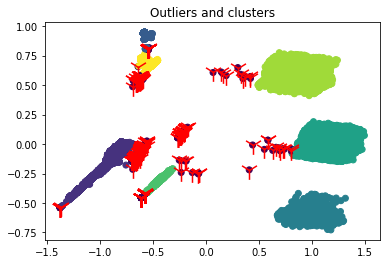

In [34]:
X_test_pca = pd.DataFrame(X_test_pca, columns=['1','2'])
X_test_pca['cluster'] = db.labels_
outliers=X_test_pca[X_test_pca['cluster']==-1]
colors = db.labels_


plt.title("Outliers and clusters")
plt.scatter(X_test_pca['1'], X_test_pca['2'], c = colors)
plt.scatter(outliers['1'], outliers['2'], marker='1', c='r', s=350 )